<a href="https://colab.research.google.com/github/amanzoni1/llm_fine_tuning/blob/main/SFT_Gemma_7B_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Gemma-7B-It for Structured Output & Financial Sentiment Classification

In this notebook we transform **Gemma-7B-Instruct** into a memory-efficient, domain-specialized financial sentiment analyst—trained on a free Colab T4 GPU—that both labels headlines and emits its answers as clean JSON objects. We begin by loading the Financial PhraseBank via the Hugging Face **Datasets** library—inspecting sentence lengths, vocabulary, and **Transformers** tokenizer behavior—then turn each headline into a prompt→JSON completion pair to prepare our data for training.

For fine-tuning, we combine 4-bit quantization (via **bitsandbytes**) with LoRA adapters (via **PEFT** and **TRL**), while keeping VRAM under control through activation checkpointing. During training, we periodically evaluate on a held-out validation split to monitor generalization, track GPU and VRAM usage to maximize efficiency, and finally push our adapter-only model to the Hugging Face Hub.

After training, we achieve strong performance on the test set—first measuring token-level loss & perplexity, then running a greedy-decode pass over each headline to compute accuracy, precision, recall, and F1. The results are excellent, and we observe that lower temperatures consistently yield the cleanest JSON outputs.

In [ ]:
import getpass
import os

# Prompt for the token
hf_token = getpass.getpass('Enter your HF access token and press enter: ')

# Set the environment variable
os.environ['HF_TOKEN'] = hf_token

print("HF_TOKEN environment variable has been set.")

Enter your HF access token and press enter: ··········
HF_TOKEN environment variable has been set.


In [ ]:
model_name = "google/gemma-7b-it"
dataset_name = "financial_phrasebank"

In [ ]:
!pip install --quiet torch seaborn matplotlib
!pip install -U --quiet transformers datasets accelerate bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Load & Inspect Dataset
After installing the libraries, we load the Financial PhraseBank “sentences_75agree” split and preview its schema, size, and a few example headlines to understand the label distribution. Then we compute and visualize basic text statistics (lengths, word counts), clean and plot the top tokens (overall and finance-specific), and chart sentiment counts to spot any imbalance.  


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, load_dataset_builder

In [ ]:
# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")

In [ ]:
# Preview dataset metadata
ds_builder = load_dataset_builder(dataset_name, "sentences_75agree", trust_remote_code=True)

print("Description:\n", ds_builder.info.description[:500], "...\n")
print("Features:", ds_builder.info.features)

Description:
 The key arguments for the low utilization of statistical techniques in
financial sentiment analysis have been the difficulty of implementation for
practical applications and the lack of high quality training data for building
such models. Especially in the case of finance and economic texts, annotated
collections are a scarce resource and many are reserved for proprietary use
only. To resolve the missing training data problem, we present a collection of
∼ 5000 sentences to establish human-annota ...

Features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}


In [ ]:
# Load the data
raw = load_dataset(dataset_name, "sentences_75agree")

print("\nRaw dataset object:\n", raw)


Raw dataset object:
 DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3453
    })
})


In [ ]:
# Extract the train split
dataset = load_dataset(dataset_name, "sentences_75agree", split="train")

print("\nDataset object:\n", dataset)
print(f"\nUsing 'train' split with {len(dataset)} examples.")


Dataset object:
 Dataset({
    features: ['sentence', 'label'],
    num_rows: 3453
})

Using 'train' split with 3453 examples.


### Sample Sentences


In [ ]:
# get the label names from the ClassLabel feature
label_names = dataset.features["label"].names

for label_id, label_name in enumerate(label_names):
    print(f"\n{label_name.upper()} examples:")
    # filter down to this label, then select the first 3
    examples = (
        dataset
        .filter(lambda ex: ex["label"] == label_id)
        .select(range(3))
    )
    for i, ex in enumerate(examples, start=1):
        print(f"  {i}. {ex['sentence']}")


NEGATIVE examples:
  1. Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
  2. Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .
  3. However , the growth margin slowed down due to the financial crisis .

NEUTRAL examples:
  1. According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
  2. At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
  3. In Sweden , Gallerix accumulated SEK denominated sales were down 1 % and EUR denominated sales were up 11 % .

POSITIVE examples:
  1. With the new production plant the company would 

### Sentiment Distribution



Neutral  : 2146 (62.1%)
Positive : 887 (25.7%)
Negative : 420 (12.2%)


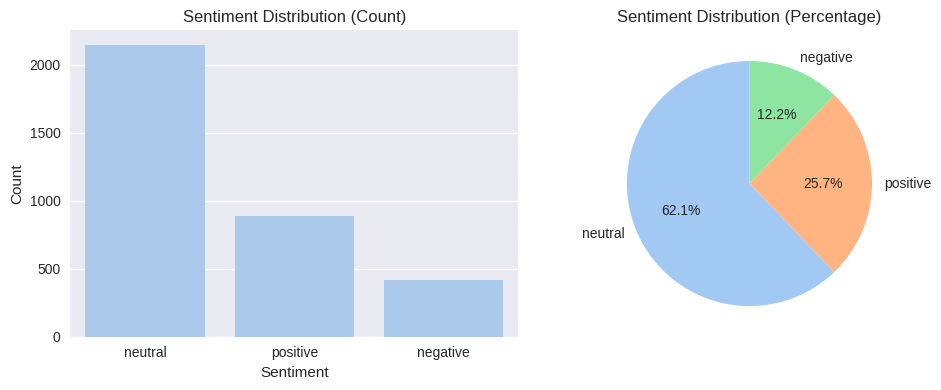

In [ ]:
from collections import Counter

# Build label→count mapping
label_names = dataset.features["label"].names
counts = Counter(label_names[l] for l in dataset["label"])
total = sum(counts.values())

# Print counts and percentages
for name, cnt in counts.items():
    pct = cnt / total * 100
    print(f"{name.capitalize():9s}: {cnt} ({pct:.1f}%)")

# Plot count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Bar chart (Count)
sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax1)
ax1.set_title("Sentiment Distribution (Count)")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

# Pie chart (Percentage)
ax2.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%", startangle=90)
ax2.set_title("Sentiment Distribution (Percentage)")

plt.tight_layout()
plt.show()

### Text Characteristics Analysis

Overall statistics:
 • Avg characters   : 124.9
 • Avg words        : 22.8
 • Avg word length  : 4.5

By-sentiment averages:
         char_count       word_count       avg_word_length     
               mean   std       mean   std            mean  std
label                                                          
negative      126.4  53.8       24.5  10.1             4.2  0.6
neutral       120.9  56.6       21.5   9.8             4.7  0.7
positive      133.6  56.3       24.9  10.3             4.4  0.7


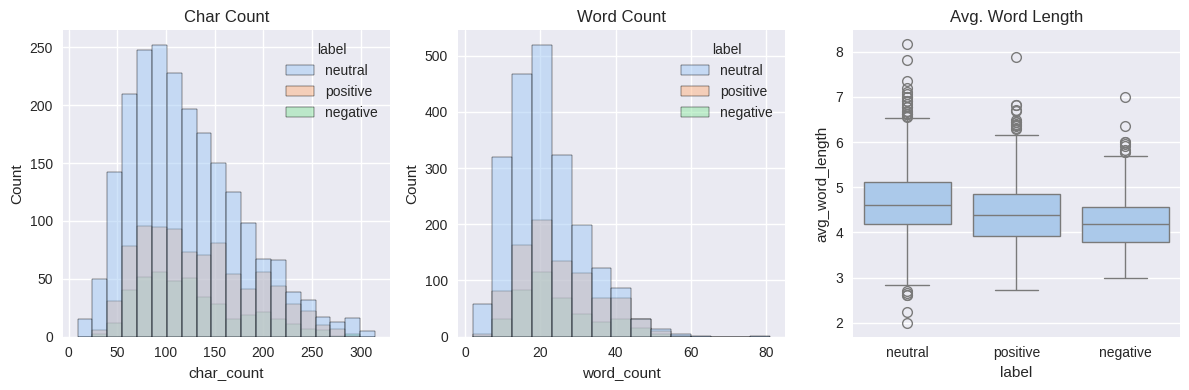

In [ ]:
df = pd.DataFrame(dataset)

# Compute metrics
df["char_count"]     = df["sentence"].str.len()
df["word_count"]     = df["sentence"].str.split().str.len()
df["avg_word_length"]= df["sentence"].apply(lambda s: np.mean([len(w) for w in s.split()]))

# Print overall stats
print("Overall statistics:")
print(f" • Avg characters   : {df['char_count'].mean():.1f}")
print(f" • Avg words        : {df['word_count'].mean():.1f}")
print(f" • Avg word length  : {df['avg_word_length'].mean():.1f}")

# Distribution by sentiment
print("\nBy-sentiment averages:")
stats = df.groupby(df["label"].map(lambda i: dataset.features["label"].names[i])) \
           .agg({
             "char_count":     ["mean","std"],
             "word_count":     ["mean","std"],
             "avg_word_length":["mean","std"]
           }).round(1)
print(stats)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df, x="char_count",   hue=df["label"].map(lambda i: dataset.features["label"].names[i]),
             kde=False, ax=axes[0], bins=20).set(title="Char Count")
sns.histplot(df, x="word_count",   hue=df["label"].map(lambda i: dataset.features["label"].names[i]),
             kde=False, ax=axes[1], bins=15).set(title="Word Count")
sns.boxplot(x=df["label"].map(lambda i: dataset.features["label"].names[i]),
            y="avg_word_length", data=df, ax=axes[2]).set(title="Avg. Word Length")
plt.tight_layout()
plt.show()

Cleaned vocabulary (no numbers, no stopwords)
eur         : 916
company     : 577
profit      : 385
net         : 379
sales       : 377
million     : 366
finnish     : 350
said        : 344
year        : 338
operating   : 258
mln         : 255
quarter     : 237
group       : 237
period      : 236
finland     : 228
share       : 193
business    : 186
oyj         : 168
new         : 166
shares      : 166


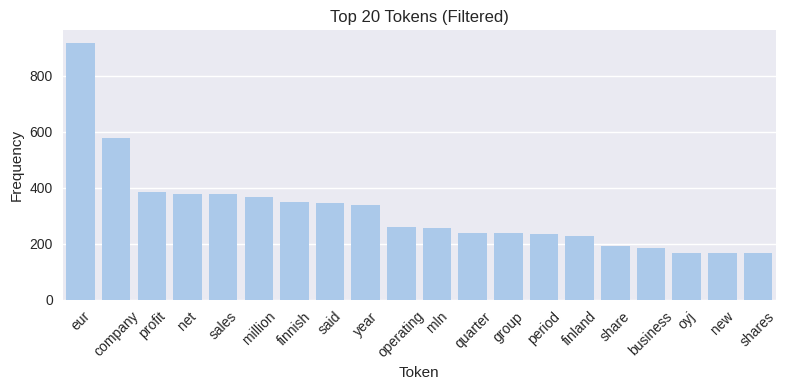

In [ ]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Build stopword set + punctuation
stopwords = set(ENGLISH_STOP_WORDS) | set(string.punctuation)

# Tokenize & filter out stopwords, tokens containing digits, and very short tokens
tokens = []
for sent in df["sentence"].str.lower():
    words = re.findall(r'\b\w+\b', sent)
    for w in words:
        if (
            w not in stopwords           # not a stopword/punctuation
            and not re.search(r'\d', w)  # no digits
            and len(w) > 2               # longer than 2 chars
        ):
            tokens.append(w)

# Get top 20 tokens now
freq = Counter(tokens)
top20 = freq.most_common(20)


print("Cleaned vocabulary (no numbers, no stopwords)")

for word, count in top20:
    print(f"{word:12s}: {count}")

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=[w for w,_ in top20], y=[c for _,c in top20])
plt.title("Top 20 Tokens (Filtered)")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

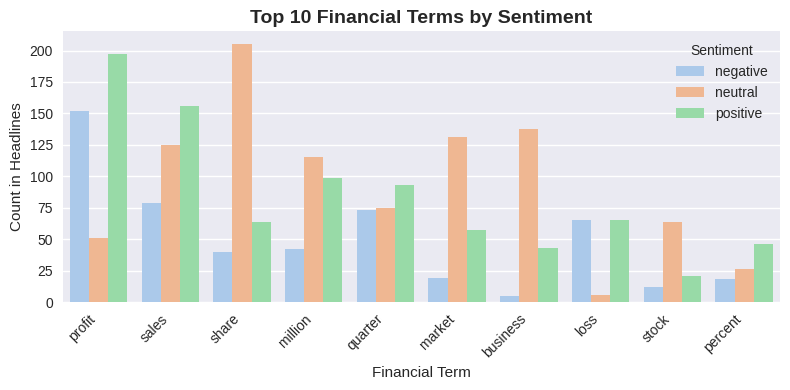

In [ ]:
# Define your terms and prepare a list of (term, sentiment, count)
financial_terms = [
    'revenue', 'profit', 'loss', 'earnings', 'growth', 'decline',
    'stock', 'share', 'dividend', 'quarter', 'market', 'sales',
    'analyst', 'forecast', 'billion', 'million', 'percent', 'business',
    'beat', 'miss', 'guidance', 'outlook', 'performance', 'results'
]

records = []
label_names = dataset.features["label"].names

for label_id, label_name in enumerate(label_names):
    # extract all sentences for this sentiment
    sub = df[df["label"] == label_id]["sentence"].str.lower()
    # count each term
    term_counts = {term: sub.str.contains(term, regex=False).sum() for term in financial_terms}
    for term, cnt in term_counts.items():
        records.append({"term": term, "sentiment": label_name, "count": cnt})

# Build a DataFrame and pick top N terms overall
term_df = pd.DataFrame(records)
overall = term_df.groupby("term").sum().sort_values("count", ascending=False).head(10).index.tolist()
plot_df = term_df[term_df["term"].isin(overall)]

# Plot grouped bar chart
plt.figure(figsize=(8, 4))
sns.barplot(
    data=plot_df,
    x="term", y="count", hue="sentiment",
    order=overall
)
plt.title("Top 10 Financial Terms by Sentiment", fontsize=14, fontweight='bold')
plt.xlabel("Financial Term")
plt.ylabel("Count in Headlines")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Tokenizer
We load Gemma’s tokenizer and inspect its vocabulary size, maximum sequence length, and special tokens, then tokenize all headlines (with truncation) to measure token counts and plot overall and per-sentiment distributions.  
Next, we identify the top 20 subword tokens by frequency and display sample headline tokenizations to see how the tokenizer handles punctuation, numbers, and financial terms.  


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
# Tokenizer Properties

print(f"Vocab size       : {tokenizer.vocab_size}")
print(f"Max model length : {tokenizer.model_max_length}")
print(f"Special tokens   : {tokenizer.all_special_tokens}")

Vocab size       : 256000
Max model length : 1000000000000000019884624838656
Special tokens   : ['<bos>', '<eos>', '<unk>', '<pad>', '<start_of_turn>', '<end_of_turn>']


### Token Length Analysis


Overall token count stats:
count    3453.0
mean       31.5
std        15.5
min         3.0
25%        21.0
50%        29.0
75%        39.0
max       183.0
Name: token_count, dtype: float64


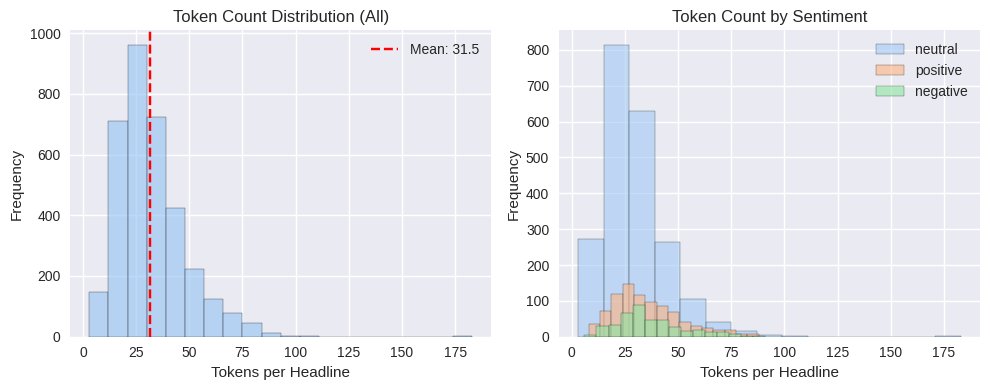

In [ ]:
# Compute token counts for each headline
token_lengths = [
    len(tokenizer(sentence, truncation=True, max_length=200)["input_ids"])
    for sentence in df["sentence"]
]
df["token_count"] = token_lengths

print("\nOverall token count stats:")
print(df["token_count"].describe().round(1))


# Plot side-by-side distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# a) All headlines
ax1.hist(token_lengths, bins=20, alpha=0.7, edgecolor='black')
ax1.set_title("Token Count Distribution (All)")
ax1.set_xlabel("Tokens per Headline")
ax1.set_ylabel("Frequency")
ax1.axvline(np.mean(token_lengths), color="red", linestyle="--", label=f"Mean: {np.mean(token_lengths):.1f}")
ax1.legend()

# b) By
plot_order = [1, 2, 0]
for label_id in plot_order:
    lengths = df[df["label"] == label_id]["token_count"]
    ax2.hist(lengths, bins=15, alpha=0.6, label=label_names[label_id], edgecolor='black')

ax2.set_title("Token Count by Sentiment")
ax2.set_xlabel("Tokens per Headline")
ax2.set_ylabel("Frequency")
ax2.legend()

plt.tight_layout()
plt.show()

### Tokenization Examples

Top 20 Subwords (Filtered)
0           : 4530
▁           : 4378
▁.          : 3669
▁,          : 3318
▁the        : 3243
2           : 2507
▁of         : 2304
1           : 2143
▁in         : 1939
.           : 1887
▁and        : 1791
▁to         : 1699
▁EUR        : 1184
▁a          : 1117
5           : 1064
3           : 1055
The         : 972
-           : 971
9           : 853
8           : 848


<ipython-input-41-58c73c8533c7>:24: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


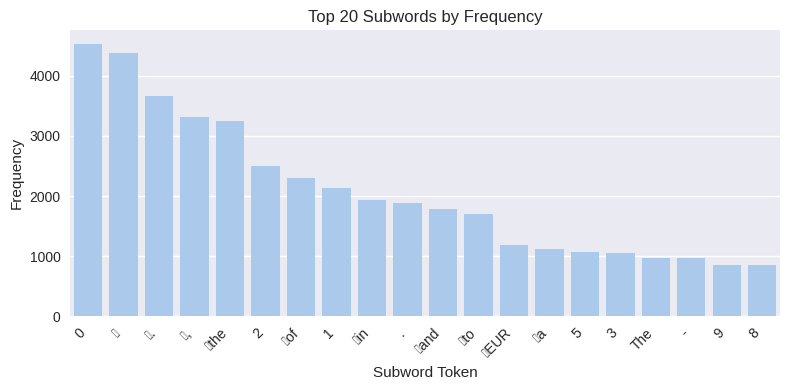

In [ ]:
# Flatten all token IDs, then convert to tokens
all_ids = [
    tid
    for sentence in df["sentence"]
    for tid in tokenizer(sentence)["input_ids"]
    if tid not in tokenizer.all_special_ids
]
all_tokens = [tokenizer.convert_ids_to_tokens(tid) for tid in all_ids]

subword_counts = Counter(all_tokens).most_common(20)
subwords, counts = zip(*subword_counts)

print("Top 20 Subwords (Filtered)")

for tok, cnt in subword_counts:
    print(f"{tok:12s}: {cnt}")

plt.figure(figsize=(8, 4))
sns.barplot(x=list(subwords), y=list(counts))
plt.title("Top 20 Subwords by Frequency")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Subword Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
print("Sample Sentence Tokenizations")

sample_sentences = [
    "Apple reports record Q3 revenue growth of 15%",
    "Tesla stock plunges after disappointing earnings",
    "Fed raises rates by 0.25 bps amid inflation concerns"
]

for sentence in sample_sentences:
    toks = tokenizer.tokenize(sentence)
    print(f"\nSentence: {sentence}")
    print(f"Tokens ({len(toks)}): {toks}")

Sample Sentence Tokenizations

Sentence: Apple reports record Q3 revenue growth of 15%
Tokens (12): ['Apple', '▁reports', '▁record', '▁Q', '3', '▁revenue', '▁growth', '▁of', '▁', '1', '5', '%']

Sentence: Tesla stock plunges after disappointing earnings
Tokens (7): ['Tesla', '▁stock', '▁plung', 'es', '▁after', '▁disappointing', '▁earnings']

Sentence: Fed raises rates by 0.25 bps amid inflation concerns
Tokens (13): ['Fed', '▁raises', '▁rates', '▁by', '▁', '0', '.', '2', '5', '▁bps', '▁amid', '▁inflation', '▁concerns']


# Formatting Data
We implement a `format_example` function to convert each headline + label into a single prompt→JSON completion, tokenize it with padding/truncation, and generate attention and label masks so the model only only learns the JSON completion.  
Next, we run a quick formatting check on a small sample—decoding both the full sequences and the masked labels—to verify that only the sentiment field in our structured output is being supervised during fine-tuning.



In [ ]:
# Mapping Function

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

label_names = dataset.features["label"].names
label_map = {i: name.upper() for i, name in enumerate(label_names)}


def format_example(example):
    # Map label → sentiment
    idx = example["label"]
    sentiment_label = label_map[idx]

    # Build the full text
    prompt = (
        'Analyze the sentiment of this financial headline and respond with JSON format.\n\n'
        f'Input: "{example["sentence"]}"\n'
        'Output: '
    )
    completion = f'{{"sentiment": "{sentiment_label}"}}'
    full_text = prompt + completion

    # Tokenize the full text
    full_tokens = tokenizer(
        full_text,
        truncation=True,
        max_length=200,
        padding="max_length",
        return_tensors=None,
        add_special_tokens=True
    )
    input_ids = full_tokens["input_ids"]
    attention_mask = full_tokens["attention_mask"]

    # Find completion by tokenizing it separately and searching for it in the full tokenization
    completion_tokens = tokenizer(completion, add_special_tokens=False)["input_ids"]

    # Find where completion_tokens start in input_ids
    completion_start_idx = None
    for i in range(len(input_ids) - len(completion_tokens) + 1):
        # Check if completion_tokens match at position i
        match = True
        for j, comp_token in enumerate(completion_tokens):
            if i + j >= len(input_ids) or input_ids[i + j] != comp_token:
                match = False
                break
        if match:
            completion_start_idx = i
            break

    # Fallback: if we can't find exact match, use approximate method
    if completion_start_idx is None:
        prompt_tokens = tokenizer(prompt, add_special_tokens=True)["input_ids"]
        completion_start_idx = len(prompt_tokens) - 1  # -1 to account for potential overlap

    # Build labels: -100 for prompt, actual IDs for completion
    labels = [-100] * len(input_ids)

    # Mark completion tokens for supervision
    for i in range(completion_start_idx, len(input_ids)):
        if input_ids[i] != tokenizer.pad_token_id:
            labels[i] = input_ids[i]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

### Formatting Check


In [ ]:
# Tokenized length stats
def analyze_tokenized_lengths(dataset_sample):
    lengths = []
    for example in dataset_sample:
        out = format_example(example)
        # count non-pad tokens
        actual_len = sum(1 for tok in out["input_ids"] if tok != tokenizer.pad_token_id)
        lengths.append(actual_len)
    print(f"Sample size: {len(lengths)}")
    print(f"Mean tokens (non-pad): {np.mean(lengths):.1f}")
    print(f"Max tokens  (non-pad): {np.max(lengths)}")
    return lengths

In [ ]:
# Run on first 100 examples of your training data
sample_ds = dataset.select(range(100))
sample_lengths = analyze_tokenized_lengths(sample_ds)

# Single-example formatting
pos_idx = label_names.index("positive")
test_example = {
    "sentence": "Apple stock surges 15% after earnings beat",
    "label":    pos_idx
}
formatted = format_example(test_example)

Sample size: 100
Mean tokens (non-pad): 67.7
Max tokens  (non-pad): 109


In [ ]:
def inspect_example(example):
    out = format_example(example)
    # Full prompt + completion
    full = tokenizer.decode(out["input_ids"], skip_special_tokens=False)
    # Only the part we supervise
    label_ids = [tok for tok, lab in zip(out["input_ids"], out["labels"]) if lab != -100]
    supervised = tokenizer.decode(label_ids, skip_special_tokens=True)

    print("── Full Prompt+Completion ──\n", full, "\n")
    print("── Supervised Portion ──\n", supervised)

In [ ]:
# Debug a real dataset example
print("\n--- Debug Real Dataset Example ---")
inspect_example(dataset[1])


--- Debug Real Dataset Example ---
── Full Prompt+Completion ──
 <bos>Analyze the sentiment of this financial headline and respond with JSON format.

Input: "With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability ."
Output: {"sentiment": "POSITIVE"}<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

# Split Dataset
We split the original train split into 80/10/10 train/validation/test, then check each subset’s class distribution to ensure our hold-out sets are representative.


In [ ]:
# Capture original columns so we can remove them after mapping
orig_cols = dataset.column_names

# Split into 80/10/10 train/val/test
splits = dataset.train_test_split(test_size=0.20, seed=42)
train_ds, temp_ds = splits["train"], splits["test"]

val_test_splits = temp_ds.train_test_split(test_size=0.5, seed=42)
val_ds, test_ds = val_test_splits["train"], val_test_splits["test"]

In [ ]:
# Check split sizes
print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Train size: 2762
Val size: 345
Test size: 346


In [ ]:
# Check class distribution in the datasets
for split_name, split_ds in [
    ("Train", train_ds),
    ("Validation", val_ds),
    ("Test", test_ds)
]:
    counts = Counter(split_ds["label"])
    total = sum(counts.values())

    print(f"\n{split_name} class distribution:")
    for idx, cnt in counts.items():
        name = label_names[idx]
        print(f"  {name:8s}: {cnt} ({cnt/total*100:.1f}%)")


Train class distribution:
  neutral : 1708 (61.8%)
  negative: 329 (11.9%)
  positive: 725 (26.2%)

Validation class distribution:
  neutral : 220 (63.8%)
  negative: 43 (12.5%)
  positive: 82 (23.8%)

Test class distribution:
  neutral : 218 (63.0%)
  positive: 80 (23.1%)
  negative: 48 (13.9%)


# Mapping
We apply `format_example` to every example in each split—dropping the old columns—so each record now contains `input_ids`, `attention_mask`, and `labels`, ready for the trainer.


In [ ]:
# map with the formatting function
train_ds = train_ds.map(format_example, remove_columns=orig_cols)
val_ds = val_ds.map(format_example, remove_columns=orig_cols)
test_ds = test_ds.map(format_example, remove_columns=orig_cols)

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [ ]:
# Inspect a couple of formatted examples

for i in [50, 51]:
    print(f"\n--- Mapped Example ---")
    inp_ids = train_ds[i]["input_ids"]
    lbls = train_ds[i]["labels"]

    # full prompt+completion (with padding)
    print("Full text:\n", tokenizer.decode(inp_ids, skip_special_tokens=False))

    # supervised portion only
    supervised = [tok for tok, lab in zip(inp_ids, lbls) if lab != -100]
    print("Supervised part:", tokenizer.decode(supervised, skip_special_tokens=True))


--- Mapped Example ---
Full text:
 <bos>Analyze the sentiment of this financial headline and respond with JSON format.

Input: "Merrill Lynch analyst Campbell Morgan upgraded his recommendation on PaperlinX from `` neutral '' to `` buy '' in May ."
Output: {"sentiment": "POSITIVE"}<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

# Train
In this step we quantize Gemma-7B-it to 4-bit, inject LoRA adapters, and kick off a supervised fine-tuning loop with our SFTTrainer.  Along the way we track both our loss curves and key hardware metrics—GPU utilization and VRAM footprint—to ensure we’re squeezing maximum efficiency out of our T4.  


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTTrainer, SFTConfig

In [ ]:
# Quantize in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = "float16",
)

In [ ]:
# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
    torch_dtype = "auto",
)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# Inject LoRA adapters
peft_cfg = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = "CAUSAL_LM",
)

model = get_peft_model(model, peft_cfg)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.config.use_cache = False

In [ ]:
hub_model = "AManzoni/gemma-sentiment-finetune"

In [ ]:
# Define training arguments
sft_config = SFTConfig(
    seed = 42,
    do_train=True,
    num_train_epochs = 3.0,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 4,
    learning_rate = 2e-4,
    lr_scheduler_type = "linear",
    warmup_ratio = 0.03,
    weight_decay = 0.01,
    dataloader_num_workers = 2,
    dataloader_pin_memory = True,
    fp16 = True,
    do_eval = True,
    eval_strategy="steps",
    eval_steps = 15,
    per_device_eval_batch_size = 8,
    logging_strategy="steps",
    logging_steps = 15,
    report_to = "none",
    output_dir = "gemma-sentiment-finetune",
    overwrite_output_dir = True,
    save_strategy = "epoch",
    push_to_hub = True,
    hub_model_id = hub_model,
)

In [ ]:
# Instantiate SFTTrainer
trainer = SFTTrainer(
    model = model,
    args = sft_config,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    processing_class = tokenizer,
)

Truncating train dataset:   0%|          | 0/2762 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/345 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.809 GB of memory reserved.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
15,18.473900,10.598877
30,6.928900,7.684446
45,3.861600,2.327923
60,2.171100,1.923222
75,2.368000,2.944316
90,2.236100,1.523591
105,1.449000,1.631373
120,1.448500,1.405540
135,1.342500,1.358701
150,1.360100,1.338744


TrainOutput(global_step=261, training_loss=2.937347675191945, metrics={'train_runtime': 9660.7524, 'train_samples_per_second': 0.858, 'train_steps_per_second': 0.027, 'total_flos': 7.75694174773248e+16, 'train_loss': 2.937347675191945})

In [ ]:
# Final memory and time stats
last_log = trainer.state.log_history[-1]

# Extract runtime info
train_seconds      = last_log["train_runtime"]
samples_per_second = last_log.get("train_samples_per_second", None)

# Recompute GPU memory stats
used_memory     = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
used_for_lora   = round(used_memory - start_gpu_memory, 3)
used_pct        = round(used_memory / max_memory * 100, 3)
lora_pct        = round(used_for_lora / max_memory * 100, 3)

# Print summary
print(f"Training time      : {train_seconds:.1f} seconds ({train_seconds/60:.2f} minutes)")
if samples_per_second:
    print(f"Throughput         : {samples_per_second:.1f} samples/second")
print(f"Peak VRAM usage    : {used_memory} GB ({used_pct}% of max memory)")
print(f"VRAM for training  : {used_for_lora} GB ({lora_pct}% of max memory)")

Training time      : 9660.8 seconds (161.01 minutes)
Throughput         : 0.9 samples/second
Peak VRAM usage    : 13.705 GB (92.972% of max memory)
VRAM for training  : 6.896 GB (46.781% of max memory)


Our training and validation losses steadily declined—finishing at around 1.24 and 1.31 respectively—indicating strong convergence, though a few more steps could eke out additional gains.  Below, we plot the full train/validation loss curves to visualize that downward trend.

In [ ]:
train_entries = [
    (log['step'], log['loss'])
    for log in trainer.state.log_history
    if 'loss' in log and 'eval_loss' not in log
]

eval_entries = [
    (log['step'], log['eval_loss'])
    for log in trainer.state.log_history
    if 'eval_loss' in log
]

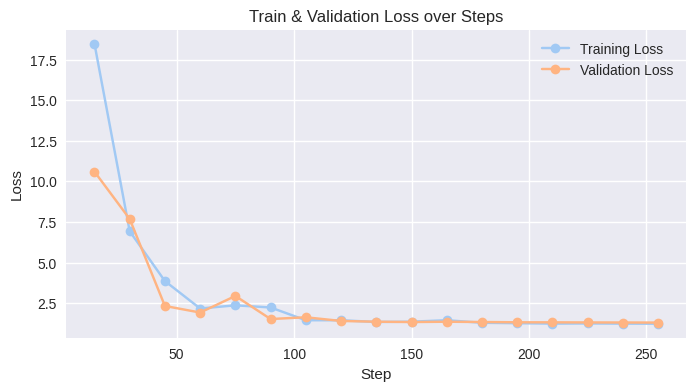

In [ ]:
train_steps, train_losses = zip(*train_entries)
eval_steps, eval_losses = zip(*eval_entries)

plt.figure(figsize=(8,4))
plt.plot(train_steps, train_losses, marker='o', label='Training Loss')
plt.plot(eval_steps, eval_losses, marker='o', label='Validation Loss')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train & Validation Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
After training, we test our fine-tuned Gemma-7B-it on held-out data. First, we compute token-level loss and perplexity on the JSON completions to verify the model’s formatting. Then we perform a greedy-decode pass over each test headline, extract the "sentiment" field, and report classification metrics (accuracy, precision, recall, F1). This confirms our adapter reliably labels unseen financial headlines.

In [ ]:
import math, json
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Token-Level Evaluation loss & perplexity) on test set
test_metrics = trainer.evaluate(test_ds)
test_loss = test_metrics["eval_loss"]
test_ppl = math.exp(test_loss)

print(f"  * test_loss        = {test_loss:.4f}")
print(f"  * test_perplexity  = {test_ppl:.2f}")

  * test_loss        = 1.2951
  * test_perplexity  = 3.65


In [ ]:
full = load_dataset(dataset_name, "sentences_75agree", split="train")
_, temp = full.train_test_split(test_size=0.20, seed=42).values()
_, test_raw = temp.train_test_split(test_size=0.5, seed=42).values()

In [ ]:
# Greedy-Decode Classification
all_preds, all_labels = [], []


def extract_sentiment(raw: str) -> str:
    raw = raw.strip()
    try:
        return json.loads(raw)["sentiment"].upper()
    except json.JSONDecodeError:
        # fallback: look for one of the labels
        m = re.search(r'\b(POSITIVE|NEUTRAL|NEGATIVE)\b', raw, re.IGNORECASE)
        return m.group(1).upper() if m else "NONE"

for ex in tqdm(test_raw, desc="Evaluating test set"):
    prompt = (
        'Analyze the sentiment of this financial headline and respond with JSON format.\n\n'
        f'Input: "{ex["sentence"]}"\n'
        'Output: '
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out_ids = model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
    )[0]
    raw = tokenizer.decode(out_ids[inputs.input_ids.shape[-1]:], skip_special_tokens=True)
    pred = extract_sentiment(raw)
    all_preds.append(pred)
    all_labels.append(label_names[ex["label"]].upper())

labels = ["POSITIVE","NEUTRAL","NEGATIVE"]
acc   = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, labels=labels, average="weighted"
)

print("\n▶Test set classification metrics")
print(f"  • Accuracy  = {acc:.3f}")
print(f"  • Precision = {prec:.3f}")
print(f"  • Recall    = {rec:.3f}")
print(f"  • F1-score  = {f1:.3f}")

Evaluating test set:   0%|          | 0/346 [00:00<?, ?it/s]


▶Test set classification metrics
  • Accuracy  = 0.942
  • Precision = 0.943
  • Recall    = 0.942
  • F1-score  = 0.942


# Inference
We reload our model from the hub and for each headline we generate both a deterministic (“greedy”) prediction and a light stochastic sample (using temperature, top_p, top_k), parse the resulting JSON output to pull out the "sentiment" field, and report it as the model’s classification.

In [ ]:
# Re-load the model + adapter re-create 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = "float16",
)

# Load the *base* Gemma-7B model in 4-bit
base = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    quantization_config = bnb_config,
)

# Attach the fine-tuned LoRA adapters
ft_model = PeftModel.from_pretrained(base, "AManzoni/gemma-sentiment-finetune")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")

# Turn off internal cache for SFT-style generation
ft_model.config.use_cache = False
ft_model.eval()

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 3072, padding_idx=0)
        (layers): ModuleList(
          (0-27): 28 x GemmaDecoderLayer(
            (self_attn): GemmaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Lin

In [ ]:
def predict_sentiment(headline: str,
                      temperature: float = 1.0,
                      top_p: float = 0.95,
                      top_k: int   = 64):
    prompt = (
        'Analyze the sentiment of this financial headline and respond with JSON format.\n\n'
        f'Input: "{headline}"\n'
        'Output: '
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(ft_model.device)
    pad_id = tokenizer.eos_token_id

    # Greedy decode
    greedy_ids = ft_model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False,
        pad_token_id=pad_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    greedy_out = tokenizer.decode(
        greedy_ids[0, inputs.input_ids.shape[-1]:],
        skip_special_tokens=True
    )

    # Sampled decode
    sample_ids = ft_model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        pad_token_id=pad_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    sample_out = tokenizer.decode(
        sample_ids[0, inputs.input_ids.shape[-1]:],
        skip_special_tokens=True
    )

    return greedy_out.strip(), sample_out.strip()


# Try it out
examples = [
    "Apple announces $20B share buyback program, lifting stock price",
    "Tesla misses Q4 delivery estimates amid supply chain woes",
    "Fed holds rates steady as inflation cools",
]

for h in examples:
    g, s = predict_sentiment(h)
    print(f"HEADLINE: {h!r}")
    print(f"  → GREEDY  : {g}")
    print(f"  → SAMPLED : {s}\n")

HEADLINE: 'Apple announces $20B share buyback program, lifting stock price'
  → GREEDY  : {"sentiment": "POSITIVE"}
  → SAMPLED : {"sentiment": "POSITIVE"}L

HEADLINE: 'Tesla misses Q4 delivery estimates amid supply chain woes'
  → GREEDY  : {"sentiment": "NEGATIVE"}
  → SAMPLED : {"sentiment": "NEGATIVE"}<unused36>

HEADLINE: 'Fed holds rates steady as inflation cools'
  → GREEDY  : {"sentiment": "NEUTRAL"}
  → SAMPLED : {"sentiment": "NEUTRAL"}

